In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [107]:
def get_loss(A, B, C):
    d = A.shape[0]
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    return - 4 * (A * B * C).sum() + 4 * d * (AA * BB * CC).sum()
    # return - 4 * (A[1:,:] * B[1:,:] * C[1:,:]).sum()
    
def get_loss2(A, B, C, t):
    indices = list(range(-(d//2), d//2+1))
    all_w = torch.zeros(d)
    for m in range(d):    
        # w = 1 if indices[0] == 0 else 0
        w = math.exp(-abs(indices[0]) * 5)
        all_w[m] = w
        indices = indices[1:] + [indices[0]]
        
    all_w  = all_w / all_w.sum()
    if t == 0:
        print(all_w)
    
    AB = A * B

    indices = list(range(-(d//2), d//2+1))
    loss = 0
    for m in range(d):
        # w = 1 if indices[0] == 0 else 0
        loss = loss + (AB[indices, :] * C).sum() * all_w[m] 
        indices = indices[1:] + [indices[0]]
        
    return - 4 * loss

def get_loss3(A, B, C):
    return - 4 * (A * B * C).sum()


In [53]:
def check_hemi(A):
    A_chop = A[1:,:]
    avg = A_chop + A_chop.flip(dims=[0])
    real_norm = avg.real.norm()
    imag_norm = avg.imag.norm()
    imag_ratio = imag_norm / math.sqrt(real_norm**2 + imag_norm**2)
    print(imag_ratio)

def keep_hemi(A):
    A[1:,:] = (A[1:,:] + A[1:,:].flip(dims=[0]).conj()) / 2

def plot_complex(M, title):
    plt.subplot(1, 2, 1)
    plt.imshow(M.real)
    plt.subplot(1, 2, 2)
    plt.imshow(M.imag)
    plt.title(title)
    plt.show()

tensor([3.0181e-07, 4.4792e-05, 6.6478e-03, 9.8661e-01, 6.6478e-03, 4.4792e-05,
        3.0181e-07])
iter: 0
analytic: (-6.116421718616039e-05-3.3417047234252095e-05j)
iter: 1000
analytic: (-10.546085357666016+0.0013376506976783276j)
iter: 2000
analytic: (-9.749478340148926-0.013758423738181591j)
iter: 3000
analytic: (-10.108154296875+0.0013183328555896878j)
iter: 4000
analytic: (-9.486412048339844-0.0010229040635749698j)
(-10.176733016967773+0.0005388673744164407j)


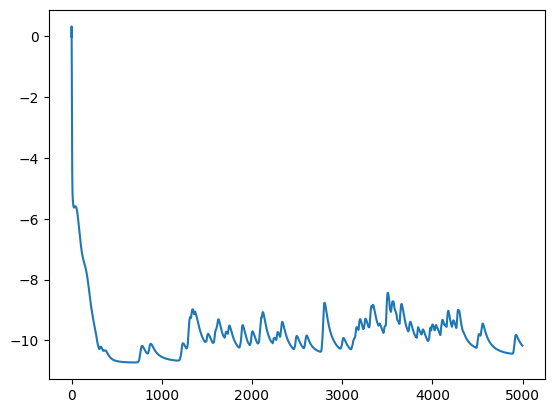

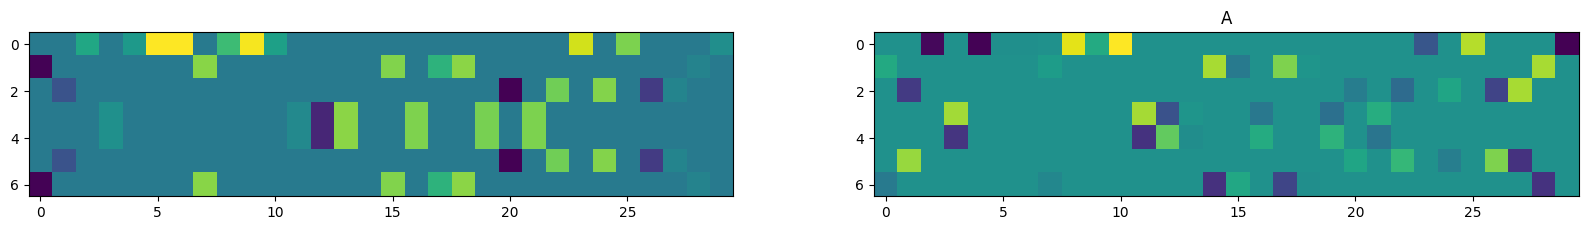

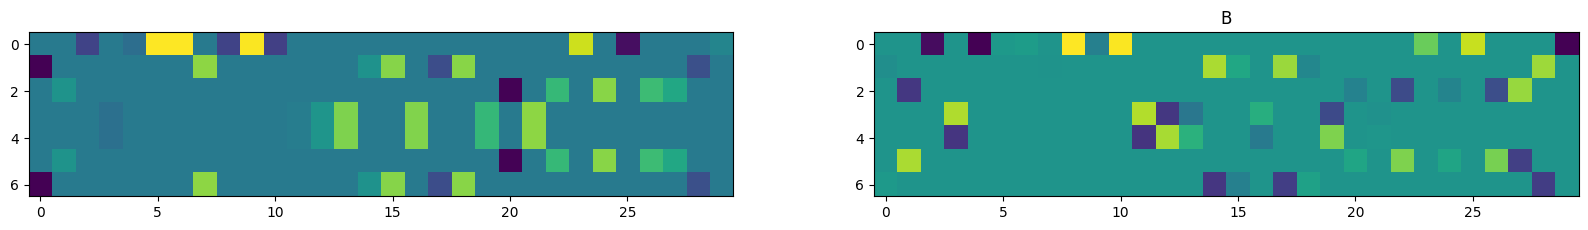

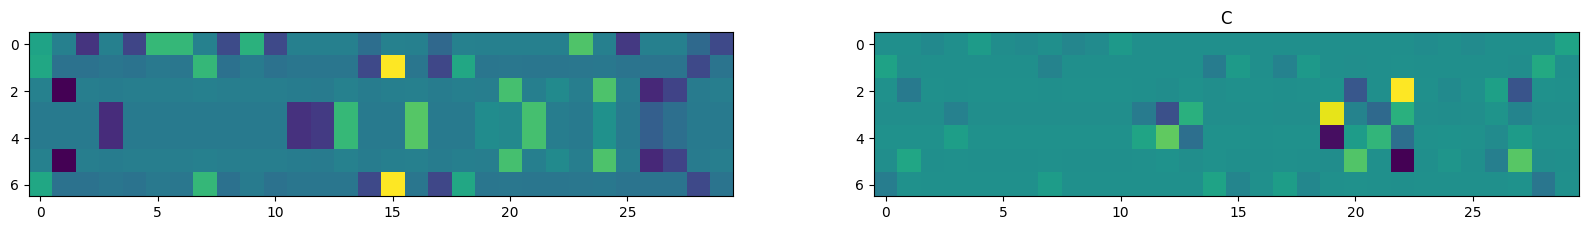

In [108]:
# let the engine compute gradient descent automatically
d = 7
# K = d - 1
K = 30

perfect_mem = False
fourier_sol = False

if perfect_mem:
    K = d * d

noise = 0.01

A = torch.rand(d, K, dtype=torch.cfloat) * noise
B = torch.rand(d, K, dtype=torch.cfloat) * noise
C = torch.rand(d, K, dtype=torch.cfloat) * noise

use_hemi = True
        
if use_hemi:
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

A = nn.Parameter(A)
B = nn.Parameter(B)
C = nn.Parameter(C)

# Then we use optimizer to optimize it
#optimizer = optim.Adam([A, B, C], lr=0.05, weight_decay=5e-3)
optimizer = optim.Adam([A, B, C], lr=0.02, weight_decay=1e-4)
nIter = 5000
# optimizer = optim.SGD([A, B, C], lr=0.05, weight_decay=3e-4)

#optimizer = optim.SGD([A, B, C], lr=0.1, weight_decay=5e-3)
#optimizer = optim.SGD([A, B, C], lr=0.01, weight_decay=5e-4)
#nIter = 1000

losses = torch.zeros(nIter, dtype=torch.cfloat)
allA = []
allB = []
allC = []
allts = []

for t in range(nIter):
    optimizer.zero_grad()
    
    # loss = get_loss3(A, B, C)
    loss = get_loss2(A, B, C, t)
        
    if t % 1000 == 0:
        print(f"iter: {t}")
        print(f"analytic: {loss.item()}")

    losses[t] = loss.item()
    loss.backward()
    optimizer.step()
    
    if use_hemi:
        with torch.no_grad():
            keep_hemi(A)
            keep_hemi(B)
            keep_hemi(C)
            
            A_norms = A.norm(dim=0, keepdim=True)
            B_norms = B.norm(dim=0, keepdim=True)
            
            norms = A_norms + B_norms
            A[:] = A / norms
            B[:] = B / norms
            
            C[:] = C - C.mean(dim=1, keepdim=True)
            C[:] = C / C.norm(dim=1, keepdim=True)
            
    if t % 100 == 0:
        allA.append(A.detach().clone())
        allB.append(B.detach().clone())
        allC.append(C.detach().clone())
        allts.append(t)


A = A.detach()
B = B.detach()
C = C.detach()

plt.plot(losses.real)

print(losses[-1].item())
plt.figure(figsize=(20, 30))
plot_complex(A, "A")
plt.figure(figsize=(20, 30))
plot_complex(B, "B")
plt.figure(figsize=(20, 30))
plot_complex(C, "C")

In [12]:

def check_constraints(A, B, C):
    diag_values = []
    off_diag_values = []

    values_a_diag = []
    values_a_off_diag = []
    values_b_diag = []
    values_b_off_diag = []

    diag_index = []
    off_diag_index = []

    for k1 in range(d):
        for k2 in range(d):
            for k3 in range(d):
                v = (A[k1, :] * B[k2, :] * C[k3, :]).sum()
                va = (A[k1, :] * A[k2, :] * C[k3, :]).sum()
                vb = (B[k1, :] * B[k2, :] * C[k3, :]).sum()

                if k1 == k2 == k3:
                    diag_values.append(v)
                    values_a_diag.append(va)
                    values_b_diag.append(vb)
                else:
                    off_diag_values.append(v)
                    values_a_off_diag.append(va)
                    values_b_off_diag.append(vb)

    diag_values = torch.stack(diag_values)
    off_diag_values = torch.stack(off_diag_values)

    va_diag_values = torch.stack(values_a_diag)
    va_off_diag_values = torch.stack(values_a_off_diag)

    vb_diag_values = torch.stack(values_b_diag)
    vb_off_diag_values = torch.stack(values_b_off_diag)

    print("ABC Off diagonal")
    print(off_diag_values.abs().max())
    print("ABC diagonal")
    print(diag_values)

    print("AAC Off diagonal")
    print(va_off_diag_values.abs().max())
    print("AAC diagonal")
    print(va_diag_values)

    print("BBC Off diagonal")
    print(vb_off_diag_values.abs().max())
    print("BBC diagonal")
    print(vb_diag_values)


    # check second terms
    AnormC = (A * A.conj()) @ C.t() 
    BnormC = (B * B.conj()) @ C.t() 

    print(AnormC.norm(), BnormC.norm())

In [58]:
check_constraints(A, B, C)

ABC Off diagonal
tensor(0.2912)
ABC diagonal
tensor([0.5590-6.5317e-08j, 0.3536+1.2340e-08j, 0.3536+4.8221e-09j,
        0.3750+9.1541e-09j, 0.3750-9.1541e-09j, 0.3536-4.8221e-09j,
        0.3536-1.2340e-08j])
AAC Off diagonal
tensor(0.2238)
AAC diagonal
tensor([0.4938-0.1515j, 0.2735+0.0039j, 0.2818-0.0105j, 0.2973-0.1239j,
        0.2973+0.1239j, 0.2818+0.0105j, 0.2735-0.0039j])
BBC Off diagonal
tensor(0.2515)
BBC diagonal
tensor([0.4938+0.1516j, 0.2735-0.0039j, 0.2818+0.0105j, 0.2973+0.1239j,
        0.2973-0.1239j, 0.2818-0.0105j, 0.2735+0.0039j])
tensor(0.0019) tensor(0.0019)


In [74]:
A[:,12]

tensor([ 3.6434e-44-3.6434e-44j,  3.6434e-44+3.6434e-44j,
         5.1239e-01-4.8729e-01j, -3.6434e-44+3.6434e-44j,
        -3.6434e-44-3.6434e-44j,  5.1239e-01+4.8729e-01j,
         3.6434e-44-3.6434e-44j])